## Vertex reconstruction in a large Directional Liquid Scintillator Detector
Training data location: https://stash.osgconnect.net/public/elagin/vtx_dir_1el_norm/

Testing data location: https://stash.osgconnect.net/public/elagin/test_vtx_dir_1el_norm/

Data are .npz files with 3 numpy arrays. Where each row correspond to one event.

"x" is a (1000,6300) array of "independent variables", photo-electron hits (theta, phi, and time). Hit coordinate encoding in each row is the folowing: \
theta = x[:,0::3] \
phi = x[:,1::3] \
time = x[:,2::3] \
All data is normalized as theta = theta/pi, phi = phi/(2pi), time = time/maxT (currently maxT=150). \
Each row in "x" is padded with -1 to make it a length of 6300 

"y_vtx" is a (1000,3) array of "dependent variable", true x-,y-,z- coordinates of the event vertex to be reconstructed \
"y_dir" is a (1000,3) array of "dependent variable", true x-,y-,z- coordinates of the unit vector along the original direction of the electron

See checking_inputs.ipynb and checking_inputs_norm.ipynb for more details on the data

In [1]:
import os
import math

import matplotlib.pyplot as plt 

import numpy as np
import pandas as pd
import random

In [2]:

from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Reshape, Lambda, Input, Concatenate, concatenate
from keras.layers import Conv1D, Conv2D, Conv2DTranspose, UpSampling2D, MaxPooling1D, MaxPooling2D, LocallyConnected2D, LocallyConnected1D
from keras.layers import LSTM, Bidirectional
from keras.layers import Masking
from keras.layers import LeakyReLU, Dropout
from keras.layers import BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.utils import to_categorical
import keras.backend as K

In [3]:
#global variables
maxT = 37
maxLambda = 800
PAD_VALUE = -1
NEvts = 1000
pi = 3.141592653589793
NFiles = 100

### Custom generator to load large datasets

In [4]:
from keras.utils import Sequence
from keras.preprocessing.sequence import pad_sequences

class MyGenerator(Sequence):
    def __init__(self, x_dir, batch_size):
        self.x_dir = x_dir
        self.x = os.listdir(x_dir)
        self.batch_size = batch_size
        print('Generator init complete')
        
    def __len__(self):
        nf = self.batch_size/(NEvts) # calculate number of files
        return math.ceil(len(self.x) / nf)

    def __getitem__(self, idx):
        batch_data = np.load(os.path.join(self.x_dir, self.x[idx]))
        Y = np.array(batch_data['y_vtx'])
        Y = np.delet(Y,2,1) # removing Z component from explicit reconstruction
        return np.array(batch_data['x']), Y

In [5]:
training_generator = MyGenerator('/data/Elagin/vtx_dir_1el_norm', NEvts)

#testing_generator = MyGenerator('/data/Elagin/test_vtx_dir_1el_color_norm', NEvts)

Generator init complete


### Loading data that can fit into RAM

In [4]:
# Load data from x_dir, stop after loading fn_max files
# Returns X, Y, Dir
# X - independent variables
# Y - dependend variables (x-, y-, z- of the vertex in this implementation)
# Dir - direction vector (x-, y-, z- componenets), could be made dependent variable
def load_test_data_to_memory(x_dir, fn_max=2000) :
    X, Y, Dir = np.array([]), np.array([]), np.array([])
    f_list = os.listdir(x_dir)
    f_list.sort()
    i=0
    for x in f_list :
        batch_data = np.load(os.path.join(x_dir, x))
        
        X = np.vstack([X, np.array(batch_data['x'])]) if X.size else np.array(batch_data['x'])
        Y = np.vstack([Y, np.array(batch_data['y_vtx'])]) if Y.size else np.array(batch_data['y_vtx'])
        Dir = np.vstack([Dir, np.array(batch_data['y_dir'])]) if Dir.size else np.array(batch_data['y_dir'])

        i+=1
        if i%10 == 0:
            print(x)
            print('i = ', i, '   ', X.shape, '   ', Y.shape, '   ', Dir.shape)
        if i>=fn_max:
            break
    Y = np.delete(Y,2,1) # removing Z component from explicit reconstruction
    print(X.shape, '   ', Y.shape, '   ', Dir.shape)
    return X, Y, Dir

In [5]:
testX, testY, trueDir = load_test_data_to_memory('/data/Elagin/test_vtx_dir_1el_norm/')

f_batch_1008.npz
i =  10     (10000, 6300)     (10000, 3)     (10000, 3)
f_batch_1018.npz
i =  20     (20000, 6300)     (20000, 3)     (20000, 3)
f_batch_1028.npz
i =  30     (30000, 6300)     (30000, 3)     (30000, 3)
f_batch_1038.npz
i =  40     (40000, 6300)     (40000, 3)     (40000, 3)
f_batch_1048.npz
i =  50     (50000, 6300)     (50000, 3)     (50000, 3)
f_batch_1058.npz
i =  60     (60000, 6300)     (60000, 3)     (60000, 3)
(69000, 6300)     (69000, 2)     (69000, 3)


In [6]:
trainX, trainY, trueDir_training = load_test_data_to_memory('/data/Elagin/vtx_dir_1el_norm/',150)

f_batch_1061.npz
i =  10     (10000, 6300)     (10000, 3)     (10000, 3)
f_batch_1070.npz
i =  20     (20000, 6300)     (20000, 3)     (20000, 3)
f_batch_108.npz
i =  30     (30000, 6300)     (30000, 3)     (30000, 3)
f_batch_1089.npz
i =  40     (40000, 6300)     (40000, 3)     (40000, 3)
f_batch_1098.npz
i =  50     (50000, 6300)     (50000, 3)     (50000, 3)
f_batch_1106.npz
i =  60     (60000, 6300)     (60000, 3)     (60000, 3)
f_batch_1115.npz
i =  70     (70000, 6300)     (70000, 3)     (70000, 3)
f_batch_1124.npz
i =  80     (80000, 6300)     (80000, 3)     (80000, 3)
f_batch_1133.npz
i =  90     (90000, 6300)     (90000, 3)     (90000, 3)
f_batch_1142.npz
i =  100     (100000, 6300)     (100000, 3)     (100000, 3)
f_batch_1151.npz
i =  110     (110000, 6300)     (110000, 3)     (110000, 3)
f_batch_1160.npz
i =  120     (120000, 6300)     (120000, 3)     (120000, 3)
f_batch_117.npz
i =  130     (130000, 6300)     (130000, 3)     (130000, 3)
f_batch_1179.npz
i =  140     (140000

### Defining various activation functions

In [7]:
def mapping_to_pmOne(x) :
    return 2*K.sigmoid(x) - 1

def mapping_to_pm50(x) :
    return mapping_to_pmOne(x)*50

def mapping_to_pm300(x) :
    return mapping_to_pmOne(x)*300

def mapping_to_0_50(x) :
    return 50*K.sigmoid(x)


def mapping_to_target_range_all( x, target_min=-0.02*pi, target_max=2.02*pi ) :
    x02 = K.tanh(x) + 1 # x in range(0,2)
    scale = ( target_max-target_min )/2.
    return  x02 * scale + target_min

def mapping_to_target_range_2pi( x, target_min=-0.00*pi, target_max=2.00*pi ) :
    x02 = K.tanh(x) + 1 # x in range(0,2)
    scale = ( target_max-target_min )/2.
    return  x02 * scale + target_min
    #return K.sigmoid(x)*target_max

def mapping_to_target_range_pi( x, target_min=-0.00*pi, target_max=1.00*pi ) :
    x02 = K.tanh(x) + 1 # x in range(0,2)
    scale = ( target_max-target_min )/2.
    return  x02 * scale + target_min
    #return K.sigmoid(x)*target_max

def mapping_to_target_range_phi( x, target_min=0, target_max=2*pi ) :
    print('is x keras tensor:', K.is_keras_tensor(x))
    print('x shape = ',K.int_shape(x))
    print('x shape = ',K.shape(x))
    #phi = K.placeholder(shape=(None,1))
    phi = Input([1])
    #theta = K.placeholder(shape=(None,1))
    theta = Input([1])
    #r = K.placeholder(shape=(None,1))
    r = Input([1])
    print('phi shape = ',K.int_shape(phi))
    print('is phi keras tensor:', K.is_keras_tensor(phi))
    phi = K.concatenate([phi, [K.tanh(x[:,1]) + 1]], axis=0) # x in range(0,2)
    #phi = K.tanh(x[:,1]) + 1
    theta = K.concatenate([theta, [x[:,0]]], axis=0)
    #theta = x[:,0]
    r = K.concatenate([r, [x[:,2]]], axis=0)
    #r = x[:,2]
    print('phi shape = ',K.int_shape(phi))
    print('is phi keras tensor:', K.is_keras_tensor(phi))
    print('theta shape = ',K.int_shape(theta))
    print('r shape = ',K.int_shape(r))
    scale = ( target_max-target_min )/2.
    phi =  phi * scale + target_min
    #phi = K.cast(phi, dtype='int32')
    #phi = K.reshape(phi, (,1))
    print('phi shape = ',K.int_shape(phi))
    
    res = K.concatenate([theta, phi, r], axis=1)
    print('res shape = ',K.int_shape(res))
    print('res shape = ',K.shape(res))
    print('is res keras tensor:', K.is_keras_tensor(res))
    x[:,1].assign(phi)
    return x

def mapping_to_target_range_phi2( x, target_min=0, target_max=2*pi ) :
    scale = ( target_max-target_min )/2.
    phi = K.placeholder(shape=(None,1))
    #phi = Input([1])
    #phi = (K.tanh(x[:,1]) + 1)*scale + target_min
    phi = K.concatenate([phi, [(K.tanh(x[:,1]) + 1)*scale + target_min]], axis=0)
    x[:,1].assign(phi)
    return x

### The model

In [8]:
def createModel():
    N=6300
    lstm_seq = 300
    lstm_steps = int(N/lstm_seq)
    model = Sequential()
    
    model.add(Reshape(input_shape=(N,), target_shape=(lstm_steps,lstm_seq)))
    
    model.add(Masking(mask_value=-1, input_shape=(lstm_steps, lstm_seq)))
    
    model.add(LSTM(75, return_sequences=True, input_shape=(lstm_steps,lstm_seq), dropout=0.0))
#     model.add(LSTM(75, return_sequences=True, input_shape=(lstm_steps,lstm_seq), dropout=0.0))
#     model.add(LSTM(75, return_sequences=True, input_shape=(lstm_steps,lstm_seq), dropout=0.0))
#     model.add(LSTM(75, return_sequences=True, input_shape=(lstm_steps,lstm_seq), dropout=0.0))
#     model.add(LSTM(75, return_sequences=True, input_shape=(lstm_steps,lstm_seq), dropout=0.0))
#     model.add(LSTM(75, return_sequences=True, input_shape=(lstm_steps,lstm_seq), dropout=0.0))
    model.add(LSTM(75, input_shape=(lstm_steps,lstm_seq), dropout=0.0))
    
    model.add(Dense(256, activation='relu'))
    #model.add(Dropout(0.1))
    model.add(Dense(256, activation='relu'))
    #model.add(Dropout(0.1))
    model.add(Dense(2, activation=mapping_to_pm300)) # removing Z component from explicit reconstruction
#    model.add(Dense(3, activation=None))
    
    return model

In [9]:
my_network=createModel()

In [10]:
my_network.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 21, 300)           0         
_________________________________________________________________
masking (Masking)            (None, 21, 300)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 21, 75)            112800    
_________________________________________________________________
lstm_1 (LSTM)                (None, 75)                45300     
_________________________________________________________________
dense (Dense)                (None, 256)               19456     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 5

### Run the model

In [11]:
batch_size = NEvts
epochs = 300

def mean_abs_theta_vtx(y_true, y_pred):
    return K.mean(K.abs(y_true[:,0] - y_pred[:,0]))
def mean_abs_phi_vtx(y_true, y_pred):
    return K.mean(K.abs(y_true[:,1] - y_pred[:,1]))
def mean_abs_r_vtx(y_true, y_pred):
    return K.mean(K.abs(y_true[:,2] - y_pred[:,2]))
def mean_abs_theta_dir(y_true, y_pred):
    return K.mean(K.abs(y_true[:,3] - y_pred[:,3]))
def mean_abs_phi_dir(y_true, y_pred):
    return K.mean(K.abs(y_true[:,4] - y_pred[:,4]))

def loss_by_R_square(y_true, y_pred):
    return K.mean(K.square(y_true[:,0] - y_pred[:,0])+
                  K.square(y_true[:,1] - y_pred[:,1])+
                  K.square(y_true[:,2] - y_pred[:,2]) )

my_network.compile(optimizer=Adam(lr=1e-5), loss='mean_squared_error')#, 
                                            #loss = loss_by_R_square)
                   #metrics=['mean_squared_error', mean_abs_theta_vtx, mean_abs_phi_vtx, mean_abs_r_vtx])#, 
                                                  #mean_abs_theta_dir, mean_abs_phi_dir])

my_network.load_weights("weights_vtx_noZ_2LSTM75_6300_300_f150_lr1e-5_N10.h5")
#my_network.load_weights("weights_vtx_dir_1el_7xLSTM75_6300_300_f1930_lr1e-5_N10.h5")


#history = my_network.fit_generator(generator=training_generator, epochs=epochs, validation_data=(testX, testY)) 

history = my_network.fit(trainX, trainY, batch_size=1000, epochs=epochs, verbose=1, validation_data=(testX, testY))


Epoch 1/300
150/150 [==============================] - 19s 127ms/step - loss: 71.1064 - val_loss: 77.5166
Epoch 2/300
150/150 [==============================] - 14s 96ms/step - loss: 70.1690 - val_loss: 76.8497
Epoch 3/300
150/150 [==============================] - 13s 88ms/step - loss: 70.0485 - val_loss: 76.9154
Epoch 4/300
150/150 [==============================] - 13s 87ms/step - loss: 70.1265 - val_loss: 77.3944
Epoch 5/300
150/150 [==============================] - 10s 68ms/step - loss: 70.4091 - val_loss: 76.8562
Epoch 6/300
150/150 [==============================] - 10s 64ms/step - loss: 70.2366 - val_loss: 82.5982
Epoch 7/300
150/150 [==============================] - 11s 71ms/step - loss: 70.4665 - val_loss: 76.8650
Epoch 8/300
150/150 [==============================] - 12s 77ms/step - loss: 70.1228 - val_loss: 77.1186
Epoch 9/300
150/150 [==============================] - 11s 74ms/step - loss: 70.0067 - val_loss: 76.8424
Epoch 10/300
150/150 [==============================] 

In [12]:
#my_network.save_weights("weights_vtx_dir_1el_color_2xLSTM75_8400_400_f250_lr1e-5_N5.h5")
my_network.save_weights("weights_vtx_noZ_2LSTM75_6300_300_f150_lr1e-5_N11.h5")

Text(0.5, 1.0, 'Loss Curves')

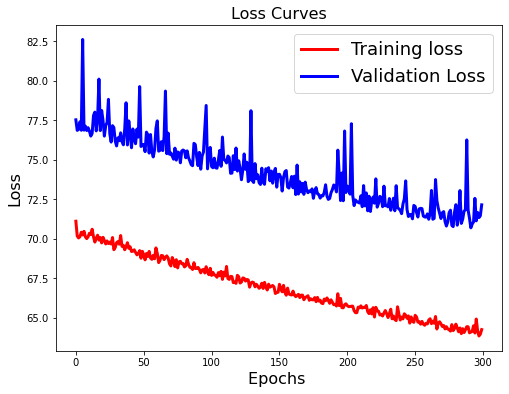

In [13]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 

In [14]:
recoY = my_network.predict(testX)

print('shape recoY = ', recoY.shape, '   shape testY = ', testY.shape)

dY = recoY - testY
dY0 = recoY[:,0] - testY[:,0]
dY1 = recoY[:,1] - testY[:,1]
#dY2 = recoY[:,2] - testY[:,2]
dR = np.sqrt((recoY[:,0] - testY[:,0])*(recoY[:,0] - testY[:,0]) + (recoY[:,1] - testY[:,1])*(recoY[:,1] - testY[:,1]) )
print(dR.shape, '  dR_mean = ', np.mean(dR))
R_true = np.sqrt(testY[:,0]*testY[:,0] + testY[:,1]*testY[:,1] )
print(R_true.shape)
print(testY.shape)

print('dY: ',dY[0:3,:])
dRb = dR.reshape(dR.shape[0],1)
dY = dY/dRb
print('dY_norm: ',dY[0:3,:])
#np.random.shuffle(trueDir)
trueDir = np.delete(trueDir, 2, 1)
vtx_dot_dir = np.sum(dY*trueDir, axis=1)
print(vtx_dot_dir.shape)

shape recoY =  (69000, 2)    shape testY =  (69000, 2)
(69000,)   dR_mean =  10.329648944685022
(69000,)
(69000, 2)
dY:  [[-3.42110042 12.30103176]
 [21.25776758 -0.25615092]
 [ 4.82884419  8.22216387]]
dY_norm:  [[-0.26794539  0.9634341 ]
 [ 0.99992741 -0.01204888]
 [ 0.50641829  0.86228795]]
(69000,)


Text(0.5, 0, 'Dot product between Vtx(bias) and Dir(el)')

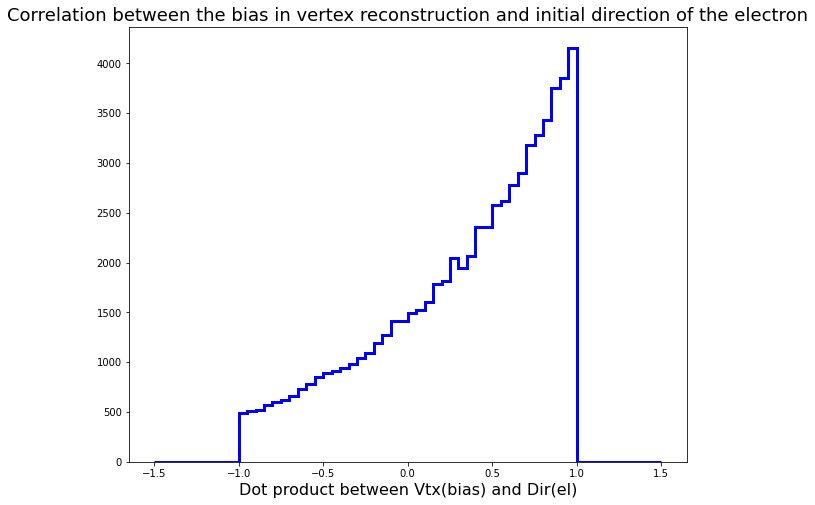

In [15]:
plt.figure(figsize=[10,8])
plt.hist(vtx_dot_dir, bins=60, range=(-1.5,1.5), histtype='step',ls='solid', alpha = 1.0, lw=3, color= 'b')
plt.title('Correlation between the bias in vertex reconstruction and initial direction of the electron', fontsize=18)
plt.xlabel('Dot product between Vtx(bias) and Dir(el)', fontsize=16)

MSE =  72.14148699269404
MSE2 =  72.14148699269404
dY0_Mean_vtx =  -1.0780318344197901    dY1_Mean_vtx =  -0.7312659220406218
dY0_Rms_vtx =  9.476605842601007     dY1_Rms_vtx =  7.380847897726151
resolution_vtx =  12.011784795998807
reco_Y1_vtx =  [ 100.695564   92.99898   -95.52401  ... -103.497185  155.87643
  167.16696 ]
test_Y1_vtx =  [  88.39453251   93.25512858 -103.74617358 ...  -95.89908356  147.26501423
  174.45347208]


Mean_true_vtx_0 =  0.670034678007085    Mean_true_vtx_1 =  -0.5676216972889134
RMS_true_vtx_0 =  134.53088806010035    RMS_true_vtx_1 =  134.04121142703264


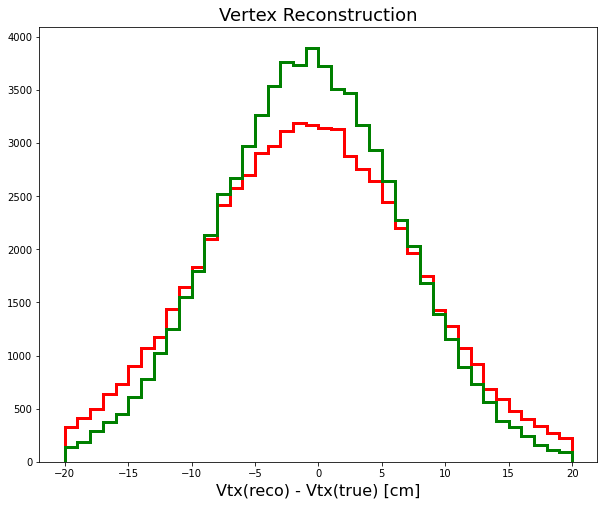

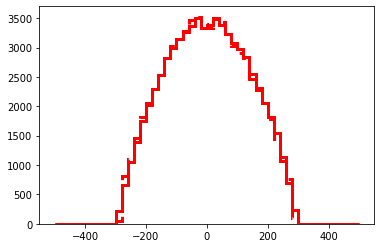

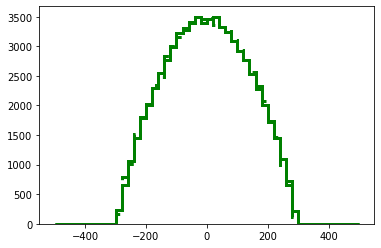

In [16]:
MSE = np.mean( (recoY.flatten()[:] - testY.flatten()[:])*(recoY.flatten()[:] - testY.flatten()[:]) )
print('MSE = ', MSE)

#MSE2 = np.mean(np.square(recoY - testY), axis=-1)
MSE2 = np.mean(np.square(recoY.flatten()[:] - testY.flatten()[:]), axis=-1)
print('MSE2 = ', MSE2)

#dTheta_dir = recoY[:,3] - testY[:,3]
#dPhi_dir = recoY[:,4] - testY[:,4]
print('dY0_Mean_vtx = ' ,np.mean(dY0), '   dY1_Mean_vtx = ', np.mean(dY1) )
print('dY0_Rms_vtx = ',np.sqrt(np.mean(np.square(dY0))), '    dY1_Rms_vtx = ',np.sqrt(np.mean(np.square(dY1))) )
print('resolution_vtx = ', np.sqrt(np.mean(np.square(dY0)) + np.mean(np.square(dY1)) ) )
#print('ThetaMean_dir = ',np.mean(dTheta_dir),'   PhiMean_dir = ',np.mean(dPhi_dir))
#print('ThetaRms_dir = ',np.sqrt(np.mean(np.square(dTheta_dir))), '   PhiRms_dir = ',np.sqrt(np.mean(np.square(dPhi_dir))))

print('reco_Y1_vtx = ',recoY[:,1])
print('test_Y1_vtx = ',testY[:,1])
print('')
print('')


#fig_scatt = plt.figure()
#plt.scatter(R_true, dR)

fig_dYs = plt.figure(figsize=[10,8])
plt.hist(dY0, bins=40, range=(-20,20), histtype='step',ls='solid', alpha = 1.0, lw=3, color= 'r')
plt.hist(dY1, bins=40, range=(-20,20), histtype='step',ls='solid', alpha = 1.0, lw=3, color= 'g')
plt.title('Vertex Reconstruction',fontsize=18)
plt.xlabel('Vtx(reco) - Vtx(true) [cm]',fontsize=16)

fig_Y0s = plt.figure()
plt.hist(recoY[:,0], bins=50, range=(-500,500), histtype='step',ls='--', alpha = 1.0, lw=3, color= 'r')
plt.hist(testY[:,0], bins=50, range=(-500,500), histtype='step',ls='solid', alpha = 1.0, lw=3, color= 'r')
fig_Y1s = plt.figure()
plt.hist(recoY[:,1], bins=50, range=(-500,500), histtype='step',ls='--', alpha = 1.0, lw=3, color= 'g')
plt.hist(testY[:,1], bins=50, range=(-500,500), histtype='step',ls='solid', alpha = 1.0, lw=3, color= 'g')

print('Mean_true_vtx_0 = ', np.mean(testY[:,0]), '   Mean_true_vtx_1 = ' , np.mean(testY[:,1]) )
print('RMS_true_vtx_0 = ' , np.sqrt(np.mean(np.square(testY[:,0]))), '   RMS_true_vtx_1 = ' , np.sqrt(np.mean(np.square(testY[:,1]))) )

In [ ]:
recoY = my_network.predict(testX)

print('shape recoY = ', recoY.shape, '   shape testY = ', testY.shape)


dTheta_vtx = recoY[:,1] - testY[:,1]
print('ThetaMean_vtx = ',np.mean(dTheta_vtx))

fig1 = plt.figure()
plt.hist(dTheta_vtx, bins=40, range=(-20,20), histtype='step',ls='solid', alpha = 1.0, lw=3, color= 'r')

fig_sinT = plt.figure()
plt.hist(recoY[:,0], bins=20, range=(-50,50), histtype='step',ls='--', alpha = 1.0, lw=3, color= 'r')
plt.hist(testY[:,0], bins=20, range=(-50,50), histtype='step',ls='solid', alpha = 1.0, lw=3, color= 'r')

fig_cosT = plt.figure()
plt.hist(recoY[:,1], bins=20, range=(-50,50), histtype='step',ls='--', alpha = 1.0, lw=3, color= 'g')
plt.hist(testY[:,1], bins=20, range=(-50,50), histtype='step',ls='solid', alpha = 1.0, lw=3, color= 'g')

fig_sinP = plt.figure()
plt.hist(recoY[:,2], bins=20, range=(-50,50), histtype='step',ls='--', alpha = 1.0, lw=3, color= 'r')
plt.hist(testY[:,2], bins=20, range=(-50,50), histtype='step',ls='solid', alpha = 1.0, lw=3, color= 'r')

#fig_cosP = plt.figure()
#plt.hist(recoY[:,3], bins=20, range=(-12,12), histtype='step',ls='--', alpha = 1.0, lw=3, color= 'g')
#plt.hist(testY[:,3], bins=20, range=(-12,12), histtype='step',ls='solid', alpha = 1.0, lw=3, color= 'g')


#fig_R = plt.figure()
#plt.hist(np.abs(recoY[:,4]), bins=20, range=(0,60), histtype='step',ls='--', alpha = 1.0, lw=3, color= 'b')
#plt.hist(testY[:,4], bins=20, range=(0,60), histtype='step',ls='solid', alpha = 1.0, lw=3, color= 'b')


In [ ]:
my_network.summary()